# Metropolis-Hastings Algorithm
### By Michael Hench

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

np.random.seed(seed=1234567)  # fix the numpy random seed for reproducibility

#### Functions
Before we begin with the actual script performing the Metropolis-Hastings algorithm itself, we must first define a few necessary functions.

First, we define an exponential decay function of the form $f(t) = a * e^{-bt}$ with two parameters ($a$ and $b$) that will serve as our signal function:

In [2]:
def exp_decay(t_in, a_in, b_in):
    """
    Returns the output of an exponential decay function of the form x = a * exp(-b * t)
    :param t_in    : (np.ndarray) vector of time values
    :param a_in    : (float) scaling factor of exponential
    :param b_in    : (float) scaling factor of time
    :return        : (np.ndarray) strength of signal w.r.t. time
    """
    return a_in * np.exp(-b_in * t_in)

Let us plot a few examples of this function to ensure it works:

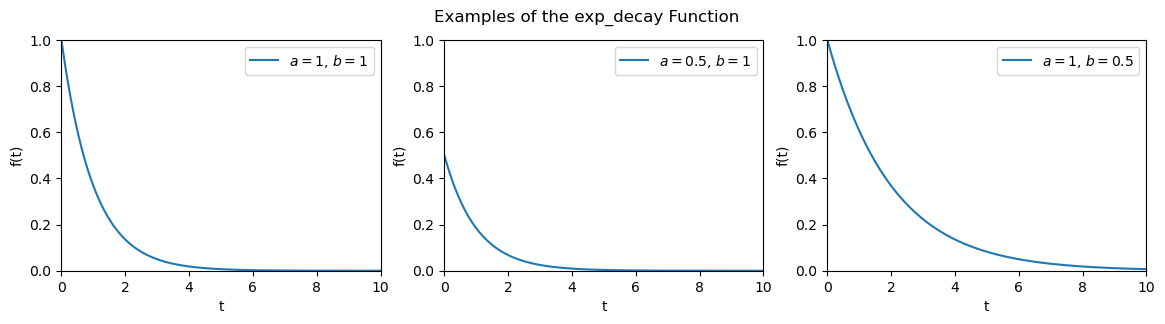

In [3]:
# create 1x3 figure for three examples of the exp_decay function working
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

# create time array
t = np.arange(0, 10, 0.01)

# plot f(t) = exp(-t)
ax[0].plot(t, exp_decay(t, 1, 1), label=f"$a=1$, $b=1$")

# plot f(t) = 0.5 * exp(-t)
ax[1].plot(t, exp_decay(t, 0.5, 1), label=f"$a=0.5$, $b=1$")

# plot f(t) = exp(-0.5 * t)
ax[2].plot(t, exp_decay(t, 1, 0.5), label=f"$a=1$, $b=0.5$")

# for each plot:
for i in ax:
    # set uniform x and y limits
    i.set_xlim([0, 10])
    i.set_ylim([0, 1])

    # label axes and add legend
    i.set_xlabel("t")
    i.set_ylabel("f(t)")
    i.legend()

# add figure super title
fig.suptitle("Examples of the exp_decay Function")
plt.show()

As can be seen, the `exp_decay` function behaves as expected: changing $a$ from $1$ to $0.5$ cut the amplitude of the signal in half, and reducing $b$ from $1$ to $0.5$ reduced the decay time by a factor of two.

Thus, we have established that the `exp_decay` function works as intended. Next, we define a data function that uses the exponential decay function above, but adds some random noise drawn from a Gaussian with mean $\mu$ and variance $\sigma^2$. While theoretically we can set this mean and variance to anything we would like using the approach in the following function, throughout the rest of this notebook we'll use the values $\mu = 0$ and $\sigma^2 = 0.01$; these values were chosen as such so that the noise wouldn't overwhelm the signal, which would result in a very large data variance.

In [4]:
def data(a0, b0, range, dt, mu=0, var=0.01):
    """
    Outputs a data signal (of form a * exp(-b * t)) with added noise drawn from a Gaussian distribution
    :param a0   : (float) scaling factor of exponential
    :param b0   : (float) scaling factor of time
    :param range: (np.ndarray) 1x2 vector with the lower and upper time bounds
    :param dt   : (float) timestep
    :param mu   : (float) mean of Gaussian distribution
    :param var  : (float) variance of Gaussian distribution
    :return     : (np.ndarray) time array
                  (np.ndarray) strength of signal w.r.t. time
    """
    # define time array, then return both it and a correlated data array
    t_out = np.arange(range[0], range[1], dt)
    return t_out, exp_decay(t_out, a0, b0) + np.random.normal(loc=mu, scale=np.sqrt(var), size=len(t_out))

Let's run a test to ensure this function works by plotting the output of the `data` function and overlaying the original exponentially-decaying signal. For this trivial case, we will choose $a=1$, $b=1$, $\mu=0$, and $\sigma^2=0.01$:

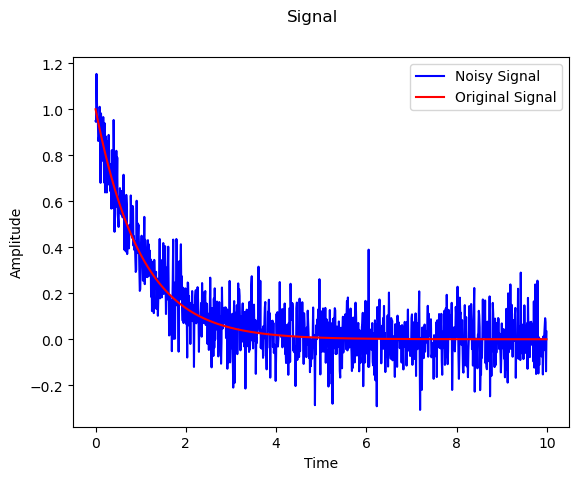

In [5]:
# generate the noisy signal
t_out, data_out = data(1, 1, np.array([0, 10]), 0.01)

# plot the noisy signal with the original signal overlaid
fig, ax = plt.subplots()
ax.plot(t_out, data_out, color='b', label='Noisy Signal')
ax.plot(t_out, exp_decay(t_out, 1, 1), color='r', label='Original Signal')

# make graph look nice
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
fig.suptitle("Signal")
plt.show()

As we can see, the function works as envisioned: it takes a signal of the form $f(t) = a * e^{-bt}$ and adds in some noise of a given $\mu$ and $\sigma^2$. We can also try changing the mean and variance inputs and ensuring they work:

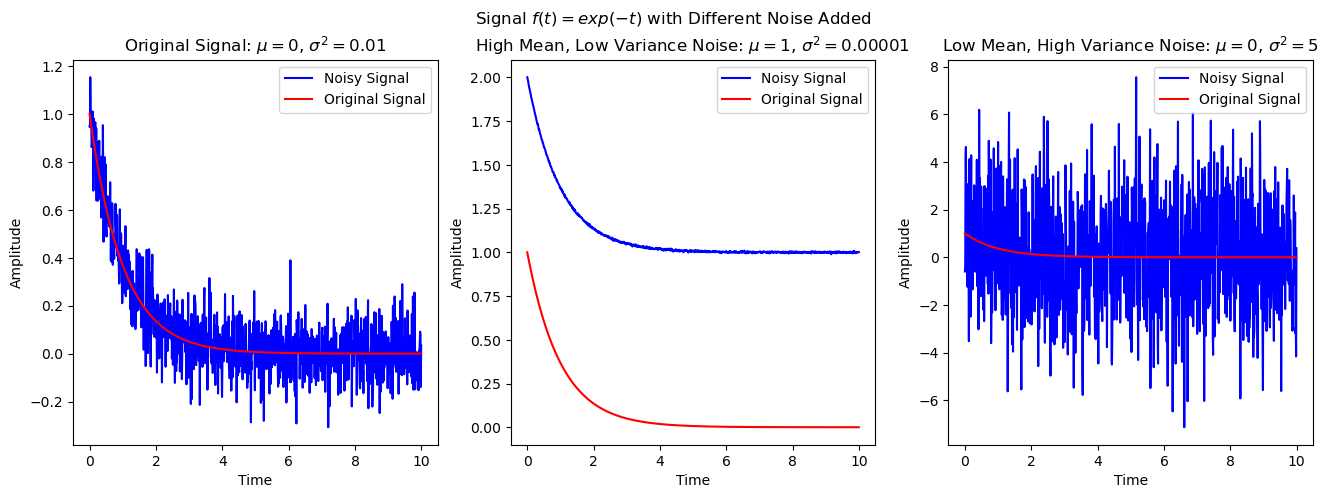

In [6]:
# generate the original noisy signal
t_out, data_out_base = data(1, 1, np.array([0, 10]), 0.01)

# generate a signal with a large mean noise but very small variance - we would expect the noise added to be fairly constant
_, data_out_small_var_noise = data(1, 1, np.array([0, 10]), 0.01, mu=1, var=0.00001)

# generate a signal with a small mean noise but very large variance - we would expect the noise added to be highly variable
_, data_out_large_var_noise = data(1, 1, np.array([0, 10]), 0.01, mu=0, var=5)

# create the figure
fig, ax = plt.subplots(1, 3, figsize=[16, 5])

# plot the original signal
ax[0].set_title(f"Original Signal: $\mu=0$, $\sigma^2=0.01$")
ax[0].plot(t_out, data_out, color='b', label='Noisy Signal')
ax[0].plot(t_out, exp_decay(t_out, 1, 1), color='r', label='Original Signal')

# plot the high mean, low variance signal
ax[1].set_title(f"High Mean, Low Variance Noise: $\mu=1$, $\sigma^2=0.00001$")
ax[1].plot(t_out, data_out_small_var_noise, color='b', label='Noisy Signal')
ax[1].plot(t_out, exp_decay(t_out, 1, 1), color='r', label='Original Signal')

# plot the low mean, high variance signal
ax[2].set_title(f"Low Mean, High Variance Noise: $\mu=0$, $\sigma^2=5$")
ax[2].plot(t_out, data_out_large_var_noise, color='b', label='Noisy Signal')
ax[2].plot(t_out, exp_decay(t_out, 1, 1), color='r', label='Original Signal')

# make graph look nice
for i in ax:
    i.legend()
    i.set_xlabel("Time")
    i.set_ylabel("Amplitude")

fig.suptitle(f"Signal $f(t) = exp(-t)$ with Different Noise Added")
plt.show()

As can be seen above, the function `data` behaves as expected: when specifying a high mean value and low variance, the function adds a fairly constant noise value to the original signal, while specifying a low mean value and high variance results in a signal where the noise completely overpowers the original signal, making it difficult to discern the original signal in the data at first glance. This latter case was something that I learned the hard way: I originally had the variance set to $\sigma^2 = 1$, but this caused very high uncertainty in the algorithm's predicitions for $a$ and $b$, as well as making the results from each run difficult to reproduce.

Before we define a function for the Metropolis-Hastings algorithm, we must define a function to calculate the acceptance ratio for the algorithm (i.e. the ratio of the posterior functions of the new a, b and old a, b). Since we know that the posterior of this function can be defined as $P \left(a, b | D \right) = \frac{1}{\beta} e^{- \frac{1}{2 \sigma^2} \sum_i \left( D_i - f \left( t_i, a, b \right) \right)^2}$, where $\beta = P \left( D \right)$ is some normalization constant. While this normalization constant would be important if we were just evaluating the posteriors themselves per se, since we only really care about the ratio of two posteriors these normalization constants cancel out and can therefore be disregarded. Since our probability distribution $Q \left(x' | x_0 \right)$ is symmetric, this acceptance ratio simplifies to $\alpha = \frac{e^{- \frac{1}{2 \sigma^2} \sum_i \left( D_i - f \left( t_i, a_{new}, b_{new} \right) \right)^2}}{e^{- \frac{1}{2 \sigma^2} \sum_i \left( D_i - f \left( t_i, a_{current}, b_{current} \right) \right)^2}} = e^{\frac{1}{2 \sigma^2} \left( \sum_i \left( D_i - f \left( t_i, a_{current}, b_{current} \right) \right)^2 - \sum_i \left( D_i - f \left( t_i, a_{new}, b_{new} \right) \right)^2 \right)}$. Essentially, it calculates the ratio of the magnitude of the posterior probability density function (PDF) function with the new values of $a_{new}, b_{new}$ versus the magnitude of the posterior PDF with the current values of $a_{current}, b_{current}$. This has been implemented in the function below:

In [7]:
def accept_ratio(data_in, t_in, a_1, b_1, a_2, b_2, var=0.01):
    """
    A function to calculate the acceptance ratio for the Metropolis-Hastings algorithm.
    :param data_in  : (np.ndarray) noisy signal array w.r.t. time
    :param t_in     : (np.ndarray) time array
    :param a_1      : (float) initial value for a
    :param b_1      : (float) initial value for b
    :param a_2      : (float) proposed value for a
    :param b_2      : (float) proposed value for b
    :param var      : (float) variance of the input data
    :return         : (float) acceptance ratio for the Metropolis-Hastings algorithm
    """
    # calculate the summation for the initial values of a, b
    sum_1 = np.sum((data_in - exp_decay(t_in, a_1, b_1))**2)

    # calculate the summation for the proposed values of a, b
    sum_2 = np.sum((data_in - exp_decay(t_in, a_2, b_2))**2)

    # return the acceptance ratio
    return np.exp((sum_1 - sum_2)/(2*var))

Finally, we define a function to execute the Metropolis-Hastings algorithm. This algorithm is a Markov Chain Monte Carlo (MCMC) algorithm for sampling a probability distribution that could otherwise be very difficult to sample. It follows four general steps:
1) Pick initial guesses for $a_0$ and $b_0$ - while these guesses don't have to be terribly close to the actual values, they provide an initial starting point for the algorithm to explore the probability distribution from. In my implementation of the algorithm, I've set the guesses to default to $[a_0 = 0.5, b_0 = 0.5]$ given that both variables are sampled randomly from a uniform distribution from $[0, 1)$. Additionally, choose a symmetric probability distribution $Q \left( \overrightarrow{x} | \overrightarrow{y} \right)$ such that $Q \left( \overrightarrow{x} | \overrightarrow{y} \right) = Q \left( \overrightarrow{y} | \overrightarrow{x} \right)$ - this will provide a rule for proposing new values of $a, b$. While this distribution can be any _symmetric_ probability density function (to satisfy the detailed balance condition), it is usually easiest to set it equal to a Gaussian, with the added perk that the path used by the algorithm to explore the probability density function then becomes a random walk.
2) Propose a new point according to the rule specified above. For the example provided, where the chosen probability distribution is a Gaussian distribution, you would draw a random point from a Gaussian with a mean value of your current point and a variance of your choice. For example, if your current values of $a$ and $b$ are $a = a_{current}$ and $b = b_{current}$, you would propose new values of $a_{new}= \mathcal{N} \left( a_{current}, \sigma^2 \right)$ and, likewise, $b_{new}= \mathcal{N} \left( b_{current}, \sigma^2 \right)$. The value you choose for your variance is a little more subjective, but you don't want to set it too large, otherwise the random walk could "jump" right over the maximum and fail to converge, instead oscillating around said maximum; likewise, if you set the variance too small, it could take an unnecessarily long time to converge, wasting CPU cycles, as well as potentially getting stuck in a local maximum.
3) Calculate the acceptance ratio for the new points. The acceptance ratio is essentially a scalar denoting how much larger the amplitude of the probability distribution is at the proposed points relative to the current points. Therefore, to calculate it, you calculate the ratio of the magnitude of the probability distribution at the new location versus at the current location. In our case, the probability distribution in question is the posterior distribution of the noisy data, meaning that you're looking to evaluate the expression $\alpha= \frac{P \left( a_{new}, b_{new}|D \right)}{P \left( a_{current}, b_{new}|D \right)}$. For the specifics for how I calculate this value in this code, please refer to my explanation of the `accept_ratio` function.
4) Decide whether to move or not. As explained earlier in this explanation, the acceptance ratio is essentially a scalar denoting how much larger the amplitude of the probability distribution is at the proposed points relative to the current points. Therefore, when deciding whether to move or not, we consider two cases:
    (1) $\alpha \geq 1$: if this is the case, then the probability distribution at the proposed location has a larger amplitude than (or at least amplitude equal to) that of the current location, meaning that the proposed points are closer to a (local) maximum than the current points. In this case, you want to move to the new location with no possibility of staying at the current location.
    (2) $\alpha < 1$: Should alpha have a value of less than one, this indicates that the probability distribution at the proposed location has a smaller amplitude than that at the current location. While it may seem counterintuitive, you would actually want to accept this move with probability $\alpha$, as doing so could help you "jump out" of any local maxima and find the true absolute maximum of the probability distribution. So, to summarize, in this scenario, accept the move with probability $\alpha$ (and conversely reject the move with probability $1-\alpha$).

In [8]:
def metro_hast(t_in, data_in, n, guess=np.array([0.5, 0.5])):
    """
    Perform the Metropolis-Hastings algorithm, presuming the data includes a signal (plus possible noise) of the form f(t) = a * exp(-b * t)
    :param t_in     : (np.ndarray) array of time values
    :param data_in  : (np.ndarray) array of noisy signal strengths w.r.t. time
    :param n        : (int) number of steps to perform
    :param guess    : (np.ndarray) 1x2 array of floats containing initial guesses for the values of [a, b]
    :return         : (np.ndarray) array of length n+1 containing the Markov chain for a
                      (np.ndarray) array of length n+1 containing the Markov chain for b
    """
    # initialize markov chain for a with initial guess
    a_mh = np.zeros(n + 1)
    a_mh[0] = guess[0]

    # initialize markov chain for b with initial guess
    b_mh = np.zeros(n + 1)
    b_mh[0] = guess[1]

    # begin iteration:
    for i in tqdm(range(n)):
        # guess new value of a and b
        new_a = a_mh[i] + np.random.normal(0, 0.01)
        new_b = b_mh[i] + np.random.normal(0, 0.01)

        # calculate accept ratio
        accept = accept_ratio(data_in, t_in, a_mh[i], b_mh[i], new_a, new_b)

        # decide whether to move
        if accept >= 1:
            a_mh[i+1] = new_a
            b_mh[i+1] = new_b
        elif np.random.rand() <= accept:
            a_mh[i+1] = new_a
            b_mh[i+1] = new_b
        else:
            a_mh[i+1] = a_mh[i]
            b_mh[i+1] = b_mh[i]

    return a_mh, b_mh

Some pitfalls that I ran into while creating this method:
1) Rather than simplifying the formula for the acceptance ratio like I ultimately ended up doing in `accept_ratio`, I had a function for the posterior (see `data_post` in *Appendix - Removed Functions*) that I evaluated for both $(a_{new}, b_{new})$ and $(a_{current}, b_{current})$, then divided the former by the latter. However, since I didn't normalize the posterior function, the resulting values (before division) were _extremely_ small, on the order of ~$10^{-230}$, breaking Python's floating point storage. Simplifying the formula solved this problem.
2) At first, rather than performing a 2D random walk, I performed two separate 1D walks, one in the space of $a$ and the other subsequently in the space of $b$. This was ineffective as it only covered an area in the ab-plane that looked like a cross, with a vertical line at one distinct $a$ value and a horizontal line at a distinct $b$ value, meaning that the _vast_ majority of the ab-plane was _not_ explored by the algorithm. This could result in the algorithm missing the absolute maximum entirely or reporting otherwise inaccurate results.

To test this function, we can create noisy data with known parameters for $a_0$ and $b_0$, run the data through the Metropolis-Hastings algorithm, then compare the algorithm's predictions to our known values of $a_0$ and $b_0$. This is, however, the prompt for this final project - so let's begin!

#### Script (Begin)

First, we define some basic variables, namely those for time, as well as random values for a and b such that $a, b \in [0, 1)$, with both rounded to three decimal places:

In [9]:
# define time from 0 to 10 in intervals of 0.001
t_range = np.array([0, 10])
dt = 0.001

# define random numbers for "known" values of parameters
a = np.round(np.random.rand(), 3)
b = np.round(np.random.rand(), 3)

We then generate noisy data:

In [10]:
# define overall data
t, exp_data = data(a, b, t_range, dt)

Now, let's graph the noisy data and overlay the original signal to visualize our dataset and (once again) ensure the `data` function is working correctly:

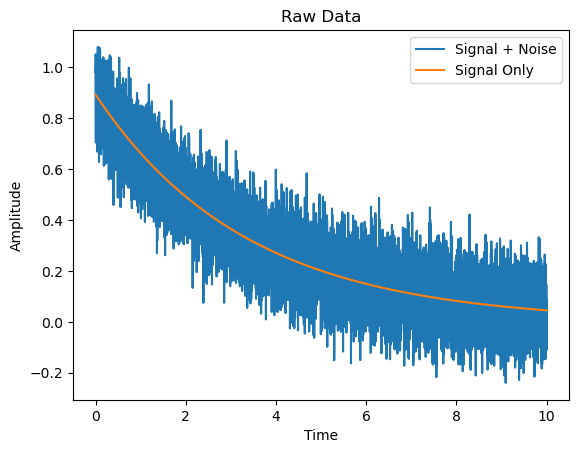

In [11]:
# plot the data to see what we're working with
fig, ax = plt.subplots()
ax.plot(t, exp_data, label="Signal + Noise")
ax.plot(t, exp_decay(t, a, b), label="Signal Only")
ax.set_xlabel("Time")
ax.set_ylabel("Amplitude")
ax.set_title(f"Raw Data")
ax.legend()
plt.show()

So far, so good - the data is noisy, but it has the distinctive shape of an exponentially-decaying data function of the form $f(t) = a e^{-bt}$. Now that we've verified that our source data is good, let's perform the Metropolis-Hastings algorithm on it to get predicted values for $a$ and $b$:

In [12]:
# perform Metropolis-Hastings algorithm
markov_a, markov_b = metro_hast(t, exp_data, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Michael\AppData\Local\Temp\ipykernel_34596\3967215351.py:20: RuntimeWarning: overflow encountered in exp
  return np.exp((sum_1 - sum_2)/(2*var))
100%|██████████| 10000/10000 [00:01<00:00, 9717.19it/s]


Let's visualize this data to make sure we're on the right path:

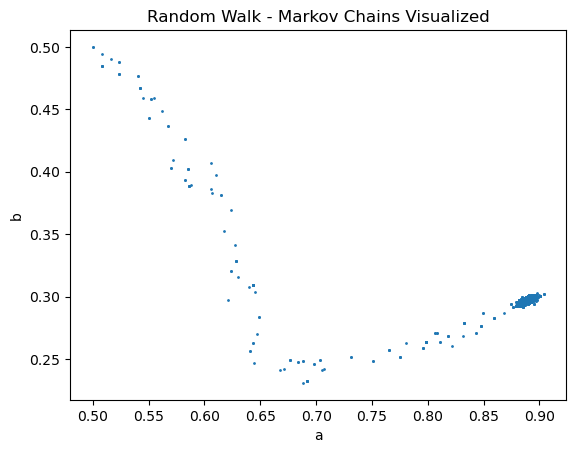

In [13]:
# plot markov chains
fig, ax = plt.subplots()
ax.set_title("Random Walk - Markov Chains Visualized")
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.plot(markov_a, markov_b, '.', markersize=2)
plt.show()

Next, we have to discard some of the data points at the beginning of the Markov chains - this is because this is because of a phenomenon called the "burn-in" period, where the function is still "walking" towards and has, therefore, not yet converged to a maximum in the posterior distribution. This is visible as the long "tail" to the left of the elliptical mass in the graph above. Because these points are essentially outliers to the probability distribution we're sampling and can throw off the overall mean and variance that we calculate at the end, we need to discard them. While the exact number of points to throw away is subjective, here I've chosen 250 points, so that I'm guaranteed to be throwing out the points during the burn-in period while simultaneously not throwing away too much of the Markov chains (given the total 10,000 points + 1 starting position, I'm only throwing out about ~2.5% of the Markov chains).

In [14]:
# discard first 250 data points (burn-in period)
markov_a = markov_a[250:]
markov_b = markov_b[250:]

Let's visualize the updated Markov chains to ensure that an adequate number of "burn-in" points were removed:

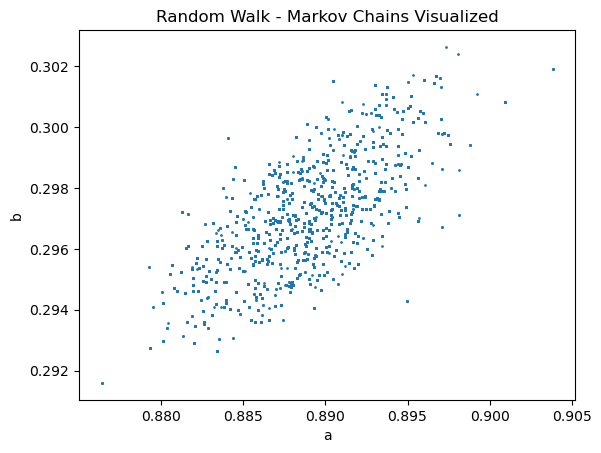

In [15]:
# plot markov chains
fig, ax = plt.subplots()
ax.set_title("Random Walk - Markov Chains Visualized")
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.plot(markov_a, markov_b, '.', markersize=2)
plt.show()

Success! We've successfully removed the burn-in points from the Markov chains, which should improve the accuracy of our algorithm. Let's find what the Metropolis-Hastings algorithm predicts for our values of $a$ and $b$: since the Markov chains for $a$ and $b$ are essentially just points contained within the probability distributions for $a$ and $b$, we can take the means of `markov_a` and `markov_b` to find the expected value of $a$ and $b$, respectively. To find the spread of our algorithm, we can use the built in NumPy function `np.var(array)` on `markov_a` and `markov_b` to find the variance of $a$ and $b$, respectively; from there, you just take the square root of the variances to find the standard deviations for both variables. Let's do this and compare our fitted values to our fiducial values:

In [16]:
# calculate mean of the markov chain of a and b
mean_a = np.mean(markov_a)
mean_b = np.mean(markov_b)

# calculate variance of markov chain of a and b
var_a = np.var(markov_a)
var_b = np.var(markov_b)

# calculate standard deviation of markov chain of a and b
sigma_a = np.sqrt(var_a)
sigma_b = np.sqrt(var_b)

# print results
print(f"Guess: a = {np.round(mean_a, 5)} " + u"\u00B1" + f" {np.round(sigma_a, 5)}, b = {np.round(mean_b, 5)} " + u"\u00B1" + f" {np.round(sigma_b, 5)}")
print(f"Actual: a = {a}, b = {b}")

Guess: a = 0.88872 ± 0.00337, b = 0.29706 ± 0.00163
Actual: a = 0.892, b = 0.298


It works! The fiducial values are within one standard deviation ($\pm \sigma$) of the fitted values! This means that, while not perfect, the algorithm is pretty good at getting a good fit for the two signal parameters. To better visualize this, let's plot the contour lines onto the graph of the Markov chains.

To do this, however, we'll need to be able to calculate $\chi^2$. To do that, we'll use code from the professor's notes posted on the course website that has been slightly modified to fit our needs (i.e. replacing `signal = a*t + b` with `signal = a*exp(-b*t)`).

In [17]:
def chi_line(data_in, a_in, b_in, t_in, s=0.1):
    """
    Find the chi squared values for a given dataset and a signal function fo the form f(t) = a * exp(-b * t) given input parameters a, b, t, and s
    :param data_in  : (np.ndarray) data array consisting of signal + noise
    :param a_in     : (float) parameter in equation that scales the exponential term
    :param b_in     : (float) parameter in equation that scales the time array
    :param t_in     : (np.ndarray) array of time values
    :param s        : (float) standard deviation of the input data
    :return         : (float) chi-squared value
    """
    noise2 = ((data_in - exp_decay(t_in, a_in, b_in))**2).sum()
    return noise2 / s**2

While we can assume the function above works given that it was essentially copied directly over from the professor's lecture notes, with the only thing that was changed was replacing his signal function with my signal function `exp_decay` that has been already tested and confirmed to be working, let's graph a hypothetical chi-squared curve with the parameters $a_{in}=[0, 1)$ and $b_{in}=b_0$ to confirm this:

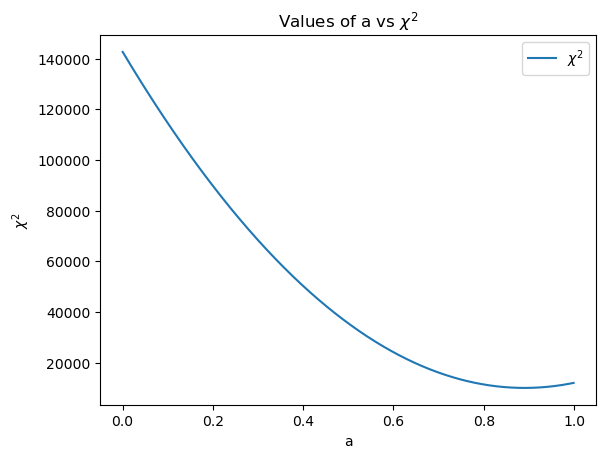

In [18]:
# create array of a values
a_test = np.arange(0, 1, 0.001)

# preallocate chi squared array
chi = np.zeros(len(a_test))

# calculate all chi squared values
for i in range(len(a_test)):
    chi[i] = chi_line(exp_data, a_test[i], b, t)

# plot
plt.xlabel("a")
plt.ylabel(f"$\chi^2$")
plt.title(f"Values of a vs $\chi^2$")
plt.plot(a_test, chi, label=f"$\chi^2$")
plt.legend()
plt.show()

So far, the shape of the graph looks right for a $\chi^2$ curve - to truly confirm, however, let's compare the value of $a$ at which the graph of the $
chi^2$ line has a minimum to our value of $a_0$. To do this, we'll use the `np.where(arg)` function to get the index of the $\chi^2$ array where its minimum value occurs (hint used from here: _https://www.geeksforgeeks.org/how-to-find-the-index-of-value-in-numpy-array/_), then access its corresponding value for $a$ in the `a_test` array:

In [19]:
# print results
print(f"Chi-squared min: a = {a_test[np.where(chi == chi.min())[0][0]]}")
print(f"Actual: a = {a}")

Chi-squared min: a = 0.89
Actual: a = 0.892


The values match up almost exactly! Now that we know our functions work, it's time to calculate the minimum $\chi^2$ value of our data so that we can graph the 68% and 95% confidence regions (i.e. $1 \sigma$ and $2 \sigma$ regions). We can do this by iterating over every point $\left( a_i, b_i \right)$, calculating its value for $\chi^2$, storing it in an array, then calling `array.min()` to find the minimum value of the array.

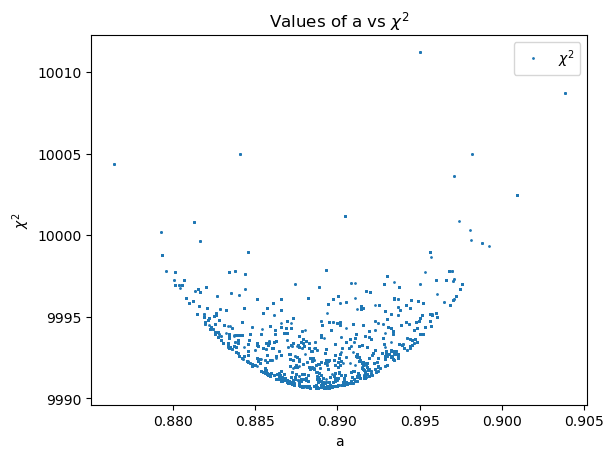

In [20]:
# preallocate chi array
chi = np.zeros(len(markov_a))

# iterate over every point in the Markov chains, calculate the Chi-squared values, and store it in an array
for i in range(len(markov_a)):
    chi[i] = chi_line(exp_data, markov_a[i], markov_b[i], t)

# plot
plt.xlabel("a")
plt.ylabel(f"$\chi^2$")
plt.title(f"Values of a vs $\chi^2$")
plt.plot(markov_a, chi, '.', markersize=2, label=f"$\chi^2$")
plt.legend()
plt.show()

The graph generated by my code above looks very similar to what I would expect - let's find the minimum $\chi^2$ value, its corresponding value of $a$, and compare it to the mean of the probability distribution to confirm that the code is working well:

In [21]:
# find minimum chi-squared value
chi_min_line = chi.min()

# print results
print(f"Chi-squared min: a = {markov_a[np.where(chi == chi_min_line)[0][0]]}")
print(f"Mean of probability distribution: a = {mean_a}")

Chi-squared min: a = 0.8888163819521366
Mean of probability distribution: a = 0.8887197878066327


The two values are almost identical, meaning that our result is confirmed and we can move on to graphing the confidence region contour lines. Before we graph the final contour lines, let us confirm using a quick counting method that the confidence intervals are correct. We know that the $\chi^2$ values for points in the 68% confidence region fall in the range of $\chi^2 \in [ \chi^2_{min}, \chi^2_{min} + 2.30]$, while those in the 95% confidence region fall in the range of $\chi^2 \in [ \chi^2_{min}, \chi^2_{min} + 6.18]$ (values are from the professor's notes from the course website). Therefore,to test and verify that these confidence regions are correct, all one has to do is to iterate through all $\chi^2$ values in the `chi` array, count how many fall into the 68% confidence region and 95% confidence region, then divide by the total number of $\chi^2$ points and convert to percentages:

In [22]:
# define chi-squared values for the upper bounds of the two confidence regions
chi_sigma_1 = chi_min_line + 2.30
chi_sigma_2 = chi_min_line + 6.18

# initialize counters for the number of points in both the 68% and 95% confidence regions
conf_68_count = 0
conf_95_count = 0

# save the total number of chi-squared points
N = len(chi)

# iterate through and count the number of points in both the 68% and the 95% confidence intervals
for chi_val in chi:
    if chi_val <= chi_sigma_2:
        conf_95_count += 1

        if chi_val <= chi_sigma_1:
            conf_68_count += 1

# save percentages for later use
conf_68_mh = np.round((conf_68_count / N) * 100, 5)
conf_95_mh = np.round((conf_95_count / N) * 100, 5)

# print the results
print(f"Percent of Markov chain points in 68% confidence interval: {conf_68_mh}%")
print(f"Percent of Markov chain points in 95% confidence interval: {conf_95_mh}%")

Percent of Markov chain points in 68% confidence interval: 67.67511%
Percent of Markov chain points in 95% confidence interval: 96.69777%


As can be seen here, the percentages of the points in each confidence interval match up very well to their expected values, with slight deviations possible due to either (a) rounding of the $\Delta \chi^2$ values and/or (b) the discrete nature of the calculation.

Having verified that the confidence regions are correct, we can now proceed to graph the confidence region contour lines. To do this, we can use, again, code from the professor's lecture notes; as code has been copied over verbatim with the only thing changed being the framing of the graph, we can assume that the code works and that we do not need to test it:

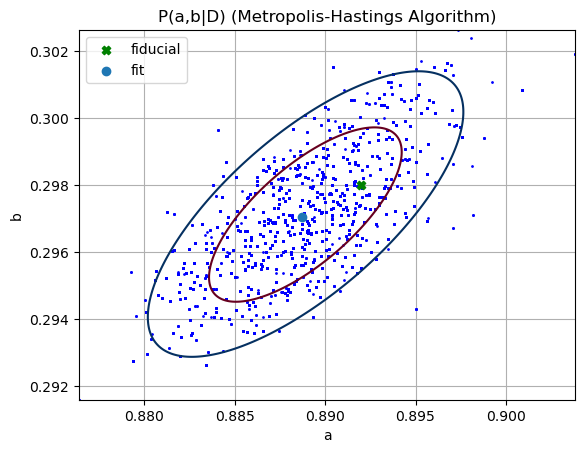

In [23]:
# define number of points in each direction on meshgrid
N = 500

# define a and b
a_r = np.linspace(markov_a.min(), markov_a.max(), N)
b_r = np.linspace(markov_b.min(), markov_b.max(), N)

# define meshgrid
A, B = np.meshgrid(a_r, b_r)

# define logP
logP = np.zeros(A.shape)
for i in range(N):
    for j in range(N):
        logP[i,j] = chi_line(exp_data, A[i,j], B[i,j], t)

# graph
fig, ax = plt.subplots()
ax.plot(markov_a, markov_b, '.', markersize=2, c='blue')
ax.contour(A, B, logP, cmap='RdBu', levels=[chi_min_line + 2.30, chi_min_line + 6.18])
ax.scatter(a, b, marker="X", c="green", label="fiducial", zorder=2)
ax.scatter(mean_a, mean_b, label="fit", zorder=2)
ax.set_title(f"P(a,b|D) (Metropolis-Hastings Algorithm)")
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.grid()
plt.show()

#### Chi-Squared Method (from class)

To confirm the results of the Metropolis-Hastings algorithm, we can calculate fitted values for $a$ and $b$ using the $\chi^2$ minimization technique that we used in class. To do this, we'll adapt code from the TA's HW solutions that are posted on the course website and that he has given me permission to reuse. First, we'll define two functions, `chisquare` and `chisquarevec`, with the former calculating the $\chi^2$ values for a given $a$, $b$, and $\sigma$, and the latter merely serving as a wrapper to vectorize the inputs into the former:

In [24]:
# adapted from HW solutions on the course website
def chisquare(a_in, b_in, s=0.1):
  return np.sum((a_in * np.exp(-b_in * t) - exp_data)**2 / (s**2))

def chisquarevec(vec):
  return chisquare(vec[0], vec[1])

Next, we'll pass the `chisquarevec` function into the `scipy.optimize.minimize()` function, along with some initial guesses for $a$ and $b$, to find guesses for the minimum values of $a$ and $b$ given our noisy data. Here we run it without assigning the output to anything to confirm that the minimization completes successfully:

In [25]:
# use the scipy minimize function to estimate values for a, b
minimize(chisquarevec, np.array([0.5, 0.5]), method="Nelder-Mead")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9990.641619599073
             x: [ 8.889e-01  2.971e-01]
           nit: 41
          nfev: 77
 final_simplex: (array([[ 8.889e-01,  2.971e-01],
                       [ 8.889e-01,  2.971e-01],
                       [ 8.889e-01,  2.971e-01]]), array([ 9.991e+03,  9.991e+03,  9.991e+03]))

Now that we know the optimization has completed successfully, we can run it again and save it into a variable named `scipy_min` to save our results:

In [26]:
# find fitted values for a and b using chi-squared minimzation
scipy_min = minimize(chisquarevec, np.array([0.5, 0.5]), method="Nelder-Mead")

To confirm that the `minimize` function works, let's compare the results from it with the actual values of $a$ and $b$:

In [27]:
# print the values (rounded to 3 decimals for readability)
print(f"Guess: a = {np.round(scipy_min.x[0], 5)}, b = {np.round(scipy_min.x[1], 5)}")
print(f"Actual: a = {a}, b = {b}")

Guess: a = 0.88891, b = 0.29711
Actual: a = 0.892, b = 0.298


The two values are very close, meaning that our result is confirmed and we can move on to graphing the confidence region contour lines. However, before we do so, let us confirm using a quick counting method that the confidence intervals are correct. To recap, we know that the $\chi^2$ values for points in the 68% confidence region fall in the range of $\chi^2 \in [ \chi^2_{min}, \chi^2_{min} + 2.30]$, while those in the 95% confidence region fall in the range of $\chi^2 \in [ \chi^2_{min}, \chi^2_{min} + 6.18]$ (values from the professor's lecture notes from the course website). Therefore, to test and verify that these confidence regions are correct, all one has to do is to iterate through all $\chi^2$ values in the `chi` array, count how many fall into the 68% confidence region and 95% confidence region, then divide by the total number of $\chi^2$ points and convert to percentages:

In [28]:
# define chi-squared values for the upper bounds of the two confidence regions
chi_sigma_1 = chi_min_line + 2.30
chi_sigma_2 = chi_min_line + 6.18

# initialize counters for the number of points in both the 68% and 95% confidence regions
conf_68_count = 0
conf_95_count = 0

# save the total number of chi-squared points
N = len(chi)

# iterate through and count the number of points in both the 68% and the 95% confidence intervals
for chi_val in chi:
    if chi_val <= chi_sigma_2:
        conf_95_count += 1

        if chi_val <= chi_sigma_1:
            conf_68_count += 1

# save percentages for later use
conf_68_chi = np.round((conf_68_count / N) * 100, 5)
conf_95_chi = np.round((conf_95_count / N) * 100, 5)

# print the results
print(f"Percent of Markov chain points in 68% confidence interval: {conf_68_chi}%")
print(f"Percent of Markov chain points in 95% confidence interval: {conf_95_chi}%")

Percent of Markov chain points in 68% confidence interval: 67.67511%
Percent of Markov chain points in 95% confidence interval: 96.69777%


As can be seen here, the percentages of the points in each confidence interval match up very well to their expected values, with once again slight deviations possible due to either (a) rounding of the $\Delta \chi^2$ values and/or (b) the discrete nature of the calculation.

Having verified that the confidence regions are correct, we can now proceed to graph the confidence region contour lines. To do this, we can use code from TA's HW solutions to plot the data with the contours. As the code is copied almost verbatim, with the only change being updating some variable names and the graph framing, we can assume it works without testing it.

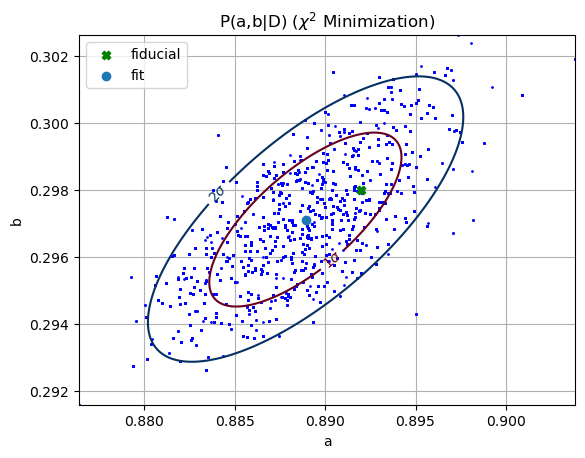

In [29]:
# define meshgrid
x = a_r
y = b_r
X, Y = np.meshgrid(x, y)

# using the suggestion on https://stackoverflow.com/a/50179459/17616747
Z = np.vectorize(chisquare)(X, Y)

# create figure and axes objects
fig2, ax2 = plt.subplots()

# plot Markov chain points for parity with Metropolis-Hastings graph
ax2.plot(markov_a, markov_b, '.', markersize=2, c='blue')

# plot contour with the +2.30 and +6.18 value correction
CS = ax2.contour(X, Y, Z, [scipy_min.fun+2.29575,scipy_min.fun+6.18007], cmap='RdBu')

# Labeling example from
#https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_label_demo.html
fmt = {}
strs = ['1$\\sigma$','2$\\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax2.clabel(CS,CS.levels,fmt=fmt,fontsize=10)

# plot fiducial and fitted values
ax2.scatter(a, b, marker="X", c="green",label="fiducial", zorder=2)
ax2.scatter(scipy_min.x[0], scipy_min.x[1], label="fit", zorder=2)

# make graph look nice
ax2.set(xlabel='a', ylabel='b', title='Contour Graph of Chi-Squared Minimization')
ax2.grid()
ax2.legend()
ax2.set_title(f"P(a,b|D) ($\chi^2$ Minimization)")
plt.show()

Finally, let's compare the results from the Metropolis-Hastings algorithm, the $\chi^2$ minimization technique, and the actual initial conditions to evaluate the effectiveness of the Metropolis-Hastings implementation here:

In [30]:
print("METROPOLIS-HASTINGS RESULTS")
print(f"Guess: a = {np.round(mean_a, 5)} " + u"\u00B1" + f" {np.round(sigma_a, 5)}, b = {np.round(mean_b, 5)} " + u"\u00B1" + f" {np.round(sigma_b, 5)}")
print(f"Percent of Markov chain points in 68% confidence interval: {conf_68_mh}%")
print(f"Percent of Markov chain points in 95% confidence interval: {conf_95_mh}%")
print()
print("CHI-SQUARED MINIMIZATION RESULTS")
print(f"Guess: a = {np.round(scipy_min.x[0], 5)}, b = {np.round(scipy_min.x[1], 5)}")
print(f"Percent of Markov chain points in 68% confidence interval: {conf_68_chi}%")
print(f"Percent of Markov chain points in 95% confidence interval: {conf_95_chi}%")
print()
print("ACTUAL INITIAL VALUES")
print(f"a = {a}, b = {b}")

METROPOLIS-HASTINGS RESULTS
Guess: a = 0.88872 ± 0.00337, b = 0.29706 ± 0.00163
Percent of Markov chain points in 68% confidence interval: 67.67511%
Percent of Markov chain points in 95% confidence interval: 96.69777%

CHI-SQUARED MINIMIZATION RESULTS
Guess: a = 0.88891, b = 0.29711
Percent of Markov chain points in 68% confidence interval: 67.67511%
Percent of Markov chain points in 95% confidence interval: 96.69777%

ACTUAL INITIAL VALUES
a = 0.892, b = 0.298


As can be seen, the guesses by the Metropolis-Hastings algorithm and the $\chi^2$ minimization algorithm as to the values of $a_0$ and $b_0$ are almost identical, and are both very close to the actual initial values. Additionally, the confidence intervals from the Metropolis-Hastings algorithm and the Chi-Squared algorithm are, for all intents and purposes, identical. Therefore, we can confirm that my code for the Metropolis-Hastings algorithm works well. QED.

#### Appendix - Removed Functions

As elaborated upon in my discussion of the `accept_ratio` function I wrote, I originally calculated the acceptance ratio $\alpha$ by calculating the posterior for both the current point set $\left( a_{current}, b_{current} \right)$ as well as for the proposed point set $\left( a_{new}, b_{new} \right)$, then dividing the latter by the former to calculate the acceptance ratio. However, since this calculation involved the division of numbers on the order of $10^{-230}$, this calculation broke Python's floating point number storage. As such, I never ended up using this method - however, it is still given as a reference for one of the approaches that I tried.

In [31]:
def data_post(data_in, t_in, a_in, b_in, var=1):
    """
    Return the posterior of the input data at given a, b values.
    :param data_in  : (np.ndarray) array giving the amplitude of the data signal w.r.t. the time array
    :param t_in     : (np.ndarray) time array
    :param a_in     : (float) scaling factor of exponential
    :param b_in     : (float) scaling factor of time
    :param var      : (float) variance of Gaussian distribution
    :return         : (float) posterior of data set at the provided parameter values
    """
    sum = np.sum((data_in - exp_decay(t_in, a_in, b_in))**2)   # calculate posterior sum that will be in exponential term
    return np.exp(-sum / (2 * var))